In [1]:
import warnings
warnings.simplefilter(action='ignore')
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import re, random, pickle, glob, os, difflib
import tensorflow as tf
import numpy as np
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import StratifiedKFold
from utils import *

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="4,5,6,7" 

In [2]:
print(tf.__version__)

2.3.1


In [3]:
train_root = 'train/'
test_root = 'test/'
model_root = 'models/'
train_set = ['x10_reads.fa']

In [4]:
df = read_fasta(train_root + train_set[0])
train_reads_original = np.array(seqs2onehot(np.array(df.seqs)))

In [5]:
train_reads = np.delete(train_reads_original,3,axis=2)
# mask = train_reads_original[...,3:4]

In [6]:
train_reads = np.expand_dims(train_reads, -1)
# mask = np.invert(np.expand_dims(mask, -1))

In [7]:
print(train_reads.shape)
# print(mask.shape)

(169538, 150, 4, 1)


In [8]:
# np.where(mask==False)

In [10]:
train_reads.shape

(169538, 150, 4, 1)

In [11]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        output = z_mean + tf.exp(0.5 * z_log_var) * epsilon
        return output

In [12]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 150 * 4
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }
    
    def call(self, x):
        x = self.encoder(x)
        return self.decoder(x)

In [13]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


In [26]:
latent_dim = 10
width = 32
input_size = (150,4,1)
filter_size = (10, 4) #10, 15, 20
epochs = 50
batch_size = 2048

In [27]:
ckpt_num = 'input_d4'
ckpt_dir = os.path.join(model_root, ckpt_num, '')
if (os.path.isdir(ckpt_dir) == False):
    os.mkdir(os.path.join(ckpt_dir, ''))

In [28]:
with strategy.scope():
    encoder_inputs = keras.Input(shape=input_size)
    x = layers.Conv2D(width, filter_size, activation="relu", strides=(2,1), padding="same")(encoder_inputs)
    x = layers.Conv2D(width, filter_size, activation="relu", strides=(2,1), padding="same")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(width, activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    print(encoder.summary())
    
    latent_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(38 * 4 * width, activation="relu")(latent_inputs)
    x = layers.Reshape((38, 4, width))(x)

    x = layers.Conv2DTranspose(width, filter_size, activation="relu", strides=(2, 1), padding="same")(x)
    x = layers.Cropping2D(cropping=((0, 1), (0, 0)))(x)

    x = layers.Conv2DTranspose(width, filter_size, activation="relu", strides=(2, 1), padding="same")(x)
    decoder_outputs = layers.Conv2D(1, filter_size, activation="sigmoid", padding="same")(x)

    decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
    print(decoder.summary())
    
    vae = VAE(encoder, decoder)
    vae.compile(optimizer=keras.optimizers.Adam(0.001))

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 150, 4, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 75, 4, 32)    1312        input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 38, 4, 32)    40992       conv2d_9[0][0]                   
__________________________________________________________________________________________________
flatten_3 (Flatten)             (None, 4864)         0           conv2d_10[0][0]                  
____________________________________________________________________________________________

In [29]:
# lr 0.0001
history = vae.fit(train_reads, epochs=epochs, batch_size=batch_size, verbose =1)

Epoch 1/50
INFO:tensorflow:batch_all_reduce: 18 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 18 all-reduces with algorithm = nccl, num_packs = 1
83/83 [==============================] - 3s 41ms/step - loss: 360.8458 - reconstruction_loss: 359.8937 - kl_loss: 0.9521
Epoch 2/50
83/83 [==============================] - 3s 40ms/step - loss: 338.6883 - reconstruction_loss: 338.2589 - kl_loss: 0.4294
Epoch 3/50
83/83 [==============================] - 3s 40ms/step - loss: 337.6677 - reconstruction_loss: 337.3494 - kl_loss: 0.3183
Epoch 4/50
83/83 [==============================] - 3s 40ms/step - loss: 336.9968 - reconstruction_loss: 336.7448 - kl_loss: 0.2520
Epoch 5/50
83/83 [==============================] - 3s 40ms/step - loss: 336.3723 - reconstruction_loss: 336.2154 - kl_loss: 0.1569
Epoch 6/50
83/83 [==============================] - 3s 40ms/step - loss: 335.8443 - reconstruction_loss: 335.7608 - kl_loss: 0.0835
Epoch 7/50
83/83 [==================

In [21]:
# lr 0.001
history = vae.fit(train_reads, epochs=epochs, batch_size=batch_size, verbose =1)

Epoch 1/50
INFO:tensorflow:batch_all_reduce: 18 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 18 all-reduces with algorithm = nccl, num_packs = 1
83/83 [==============================] - 3s 41ms/step - loss: 343.6486 - reconstruction_loss: 343.6481 - kl_loss: 5.2490e-04
Epoch 2/50
83/83 [==============================] - 3s 40ms/step - loss: 336.2361 - reconstruction_loss: 336.2351 - kl_loss: 0.0010
Epoch 3/50
83/83 [==============================] - 3s 40ms/step - loss: 335.5576 - reconstruction_loss: 335.5339 - kl_loss: 0.0237
Epoch 4/50
83/83 [==============================] - 3s 40ms/step - loss: 332.6154 - reconstruction_loss: 332.0263 - kl_loss: 0.5890
Epoch 5/50
83/83 [==============================] - 3s 40ms/step - loss: 330.0693 - reconstruction_loss: 329.1157 - kl_loss: 0.9536
Epoch 6/50
83/83 [==============================] - 3s 40ms/step - loss: 328.6144 - reconstruction_loss: 327.4041 - kl_loss: 1.2103
Epoch 7/50
83/83 [==============

In [25]:
# lr 0.01
history = vae.fit(train_reads, epochs=epochs, batch_size=batch_size, verbose =1)

Epoch 1/50
INFO:tensorflow:batch_all_reduce: 18 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 18 all-reduces with algorithm = nccl, num_packs = 1
83/83 [==============================] - 3s 41ms/step - loss: 357.5218 - reconstruction_loss: 357.5015 - kl_loss: 0.0202
Epoch 2/50
83/83 [==============================] - 3s 40ms/step - loss: 335.5530 - reconstruction_loss: 335.5514 - kl_loss: 0.0016
Epoch 3/50
83/83 [==============================] - 3s 40ms/step - loss: 335.5545 - reconstruction_loss: 335.5533 - kl_loss: 0.0011
Epoch 4/50
83/83 [==============================] - 3s 40ms/step - loss: 335.5302 - reconstruction_loss: 335.5294 - kl_loss: 7.9347e-04
Epoch 5/50
83/83 [==============================] - 3s 40ms/step - loss: 335.5134 - reconstruction_loss: 335.5129 - kl_loss: 5.3578e-04
Epoch 6/50
83/83 [==============================] - 3s 40ms/step - loss: 335.4750 - reconstruction_loss: 335.4746 - kl_loss: 3.5575e-04
Epoch 7/50
83/83 [======

KeyboardInterrupt: 

In [16]:
history = vae.fit(train_reads, epochs=epochs, batch_size=batch_size, verbose =1)

83/83 [==============================] - 2s 20ms/step - loss: 338.3851 - reconstruction_loss: 338.3850 - kl_loss: 1.0581e-04


In [24]:
train_reads[0].shape

(150, 5, 1)

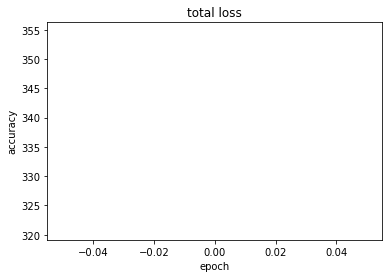

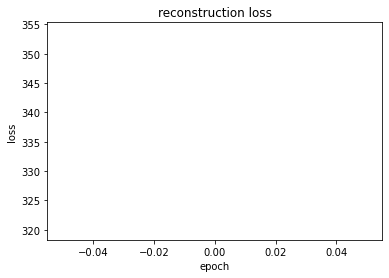

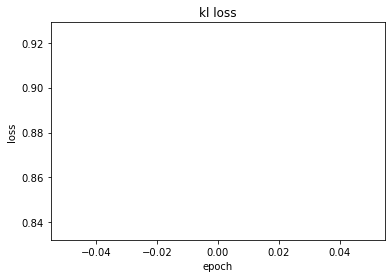

In [26]:
plt.plot(history.history['loss'])
plt.title('total loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()
# summarize history for loss
plt.plot(history.history['reconstruction_loss'])
plt.title('reconstruction loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

plt.plot(history.history['kl_loss'])
plt.title('kl loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [27]:
encoder.save('models/ckpt1/encoder.h5')

In [14]:
# test_sets = ['test_easy_1.fa', 'test_easy_2.fa', 'test_intermidate_1.fa', 'test_intermidate_2.fa', 'test_difficult_1.fa', 
#              'test_difficult_2.fa', 'test_very_difficult_1.fa', 'test_very_difficult_2.fa']
# easy_1 = assign_labels(read_fasta(test_root + test_sets[0]))
# easy_2 = assign_labels(read_fasta(test_root + test_sets[1]))

In [80]:
# easy_1_predictions = encoder.predict(train_reads)

In [67]:
# a = np.expand_dims(np.array(seqs2onehot([easy_1.loc[105487]['seqs']])), -1)
# b = encoder.predict(a)
# c = decoder.predict(b[-1]); c = np.squeeze(c)
# difflib.SequenceMatcher(None, np.argmax((c>0.01), axis=1), np.argmax(np.squeeze(a), axis=1)).ratio()

In [87]:
# np.array(b).shape

(3, 1, 16)